In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uqq fastai
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

### Inspect an image

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path) # Image class from Python Image Library PIL
im3

## Numpy array representation of pixels
Columns and Rows 4 to 10 (not included)

In [9]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

### Tensor representation

In [10]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

# Pixel representation
Display the top part of the number.

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# Classification Attempt: Average of pixels
The idea is to have all images of 3s and 7s and take an average of each pixel between all the images. The images are 28x28 pixels, so we'll take an average of each of these in every image. For this we can use a stack to create a 3D tensor that stores images and pixel data.

First we store parse the images and store them in a python list

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

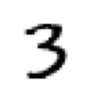

In [13]:
show_image(three_tensors[1])

Now we stack the python image tensors into one 3D tensor and we represent the pixel values (0-255) in a float between 0-1. We will have a single tensor with 6k images of 28 x 28 pixeles with values between 0-1.

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

## Jargon
Shape: Size of each axis of a tensor
Rank: Number of dimensions of a tensor

Don't confuse the term dimensions used in pytorch with spacial dimensions. A tensor of three elements can describe a point in 3D space, but it would still be a 1d tensor.

In [15]:
stacked_threes.ndim # Number of dimensions

3

## Mean of pixels
We take the mean align axis 0, that stacks all of our images. These will be our average number visualizations.

<Axes: >

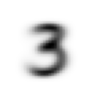

In [16]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<Axes: >

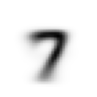

In [17]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

# Calculating the difference between number and ideal number
Idea: For each pixel calculate the difference, then average it between all pixels. The lowest difference should determine which number it is.

In [18]:
# My attempt solution of distances
print(f' mean difference 3 {tensor(mean3 - stacked_sevens[200]).mean()}')
print(f' mean difference 7 {tensor(mean7 - stacked_sevens[200]).mean()}')

# The intutition to calculate the differences is correct but I din't calculate it correctly so the numbers don't work

 mean difference 3 -0.031579095870256424
 mean difference 7 -0.05858154594898224


## Fast AI solution
### Loss function: Mean of Squares of differences
Scientists use the mean of the absolute values of differences to calculate difference or the mean of the square of the differences (Which makes it positive)

<Axes: >

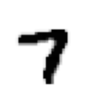

In [19]:
im7 = stacked_sevens[200]
show_image(im7)

In [20]:
dist_3_abs = (im7 - mean3).abs().mean()
dist_3_sqr = ((im7 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1840), tensor(0.3257))

In [21]:
dist_7_abs = (im7 - mean7).abs().mean() # l1_loss - Mean Absolute Error (MAE)
dist_7_mean_sq = ((im7 - mean7)**2).mean() # Mean Square Error (MSE)
dist_7_sqr = ((im7 - mean7)**2).mean().sqrt() # Root Mean Square error (RMSE)

dist_7_abs, dist_7_mean_sq, dist_7_sqr

(tensor(0.1078), tensor(0.0470), tensor(0.2168))

### l1_loss and mse_loss funtions

From the above, the difference is lower for mean7, so the prediction of this basic model is correct

Pytorch already provides both abs (MAE) and mean square (MSE) loss functions in `torch.nn.functional` imported as `F`
a) `mean of absolute difference` or `Mean Absolute Error` => `l1_loss function`, L1 Norm, or `mean absoulut value`
b) `mse_loss` function or L2 Norm, or `mean squared error (MSE)`
c) `root mean square error (RMSE)` => `mse_loss().sqrt()` => PyTorch doesn't provide a built in RMSE function, but we can combine mse_loss with sqrt to achieve it.



In [22]:
F.l1_loss(im7.float(), mean7), F.mse_loss(im7, mean7), F.mse_loss(im7, mean7).sqrt()

(tensor(0.1078), tensor(0.0470), tensor(0.2168))

## Computing Metrics Using Broadcasting
To try any model we need a validation set. The MNIST data set of numbers already had a validation set separated.

In the code below we create an array of tensors out of the images in the validation path, we sort it and convert it into a tensor structure. Then we parse the elements to floats and normalize the pixel data by dividing by 255.

In [23]:
validation_3_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()]).float()/255
validation_7_tensors = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()]).float()/255
validation_3_tensors.shape, validation_7_tensors.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

### Distance function
A function to assess wether a number is closest to our ideal seven or three

<Axes: >

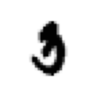

In [24]:
im3 = stacked_threes[200]
show_image(im3)

In [25]:
def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))
mnist_distance(im3, mean3)

# mean(-1, -2) means that the mean is applied to the -1 and -2 axis of our tensor (last and one-before last), or where the vertical and horizontal data
# of the images is stored.

# For a list of tensors this will imply that the mean is not calculated for all images, but for each image separately.

tensor(0.1311)

### Broadcasting
We can use the same function but passing a thensor for `a` instead of a single image, and it will still work. We get a tensor of distances.

How?
When applying an operation to tensors of different rank PyTorch will "broadcast" or expand the tensor with the lowest rank to have the same size as the higher rank one.

In this case b, a single image will be broadcasted as a rank-2 tensor of images (an array of images).

- PyTorch doesn't copy the tensor, it just pretends it is. It doesn't allocate extra memory for it.
- It makes all these calculations on the GPU


In [26]:
mnist_distance(validation_3_tensors, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

# Classification function
If the distance is smaller to mean3 then x is three.

In [27]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [28]:
is_3(im3), is_3(im3).float()

(tensor(True), tensor(1.))

We can apply the is_3 function to the whole tensore

In [29]:
is_3(validation_3_tensors)

tensor([ True,  True,  True,  ..., False,  True,  True])

# Accuracy of the predictions
We get an accuracy of over 90% for both numbers

In [30]:
accuracy_3s = is_3(validation_3_tensors).float().mean()
accuracy_7s = (1 - is_3(validation_7_tensors).float()).mean()
accuracy_3s, accuracy_7s

(tensor(0.9168), tensor(0.9854))

# Stocastic Gradient Descent

This is an iterative method where we start with random weights for a model, generate predictions, calculated loss, adjust weights based on the derivative (gradient) and repeat the process until our loss goes down.

Steps for stochastic gradient descent.
1. Initialize weights
2. Use weights to predict values (example: images are Cat or not)
3. For each element (ex. image) calculate the loss based on predictions
4. Calculate gradient => How changing weight would change loss
5. Step (Change) weights based on calculation
6. Go back to step 2 and repeat
7. Iterate until model good enough or enough time



In [31]:
# Quadratic function

def f(x): return x**2

### Derivative
A function has a derivative function which is the rate-of-change or tangent of the function at a given point.
When we know how our function will change at a certain point, then we know how to adjust it to make it's value lower. This is key in deep learning.

We use `require_grad_()` method to tell PyTorch we want to calculate derivatives.
Key distinction: In Math a derivative is another function, in PyTorch the gradient will be the value of a function's derivative at a particular point.

With require_grad_() we tag the tensor for Pytorch to calculate the derivative for it

In [32]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [33]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Now we can calculate the derivative value at the point, with backpropagation

In [34]:
yt.backward()

... And access the calculated gradient value.
The math derivative of x**2 is 2x, so the derivative value at point 3 should be 2x3 = 6

In [35]:
xt.grad

tensor(6.)

We can do it for a number of tensor values

In [36]:
def func(x):
    return (x**2).sum()

ts = tensor([4., 5., 10.]).requires_grad_()
ts

tensor([ 4.,  5., 10.], requires_grad=True)

In [37]:
yt = func(ts)

In [38]:
yt.backward()
ts.grad

tensor([ 8., 10., 20.])

## Stepping with a Learning Rate
Learning rate is the small number by which we multiply a gradient to adjust weights, usually between 0.1 and 0.001
There are methods to select the optimal learning rate, but you can pick any small number between 0.001 and 0.1

Stepping parameters
`w -= gradient(w) * lr`

This means substracting `gradient * lr` from the weight to update it, which adjusts it in the direction of the slope.
Picking a learning rate too low: Too many steps, picking one too big: Worse loss.

## End-to-end SGD example
We're going to try to apply a model to the speed of a wagong going uphill and down. We first create a function of how the speed might change with time.

In [39]:
# 20 time steps
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

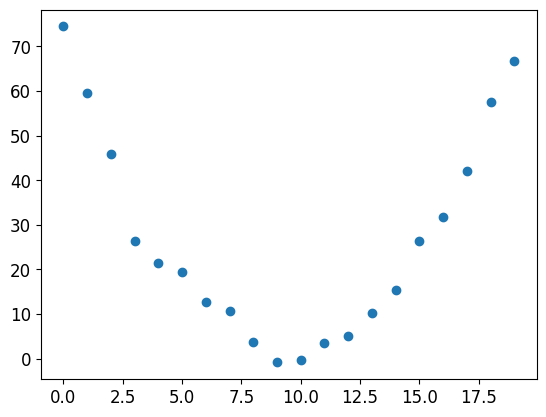

In [40]:
# A speed representation of the wagonwith a little error included
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed)

We will use a quadratic function to try to model these speeds. A quadratic function is defined by parameters a, b, and c. We will try to find the optimal values for these using SGD.

In [41]:
# Speed at time t for params a, b, c
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

### Loss function: Mean squared error

In [42]:
def mse(preds, targets):
    return ((preds - targets)**2).mean()

## 1. Init params

In [43]:
params = torch.randn(3).requires_grad_()
origin_params = params.clone()
origin_params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward0>)

## 2. Calculate predictions

In [44]:
preds = f(time, params)
preds

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

In [45]:
# Function to plot prediction and target functions
def show_preds(preds, ax=None):
    if ax is None:
        ax=plt.subplots()[1]
        ax.scatter(time, speed)
        ax.scatter(time, to_np(preds), color='red')
        ax.set_ylim(-300, 100)
    

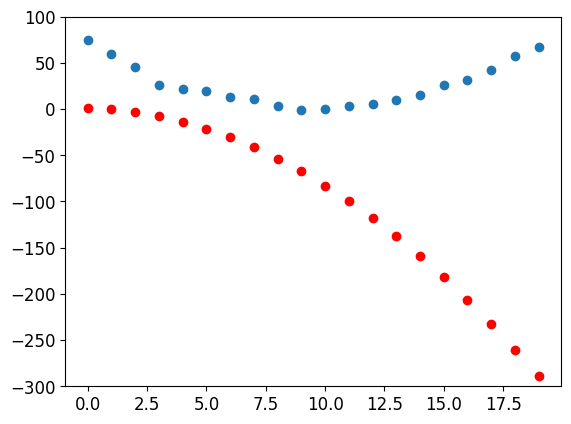

In [46]:
show_preds(preds)

### 3. Calcuate loss of the predictions

In [47]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

### Calculate gradientes
To improve the loss we first need to calculate the gradients to know how to modify the weights (a, b, c). We pick an arbitrary learning rate of `1e-5` for now.

In [48]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [49]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [50]:
# Starting a,b,c values
params.data

tensor([-0.7658, -0.7506,  1.3525])

### 5. Step the weights
Modify the weights by multiplying the gradients with the learning rate.

** Important
The params tensor contains a data property with a, b, c and a gradients "array" on the `.grad` property because we requested it. In the next line we are going to substract from each param (a, b,c) the product of the gradient by the learning rate, to generate adjusted params.

In [51]:
lr = 1e-5
params.data -= lr * params.grad.data 
params.grad = None  # => We should reser .grad in each iteration

In [52]:
# Adjusted params
params.data

tensor([-0.2339, -0.7164,  1.3551])

In [53]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

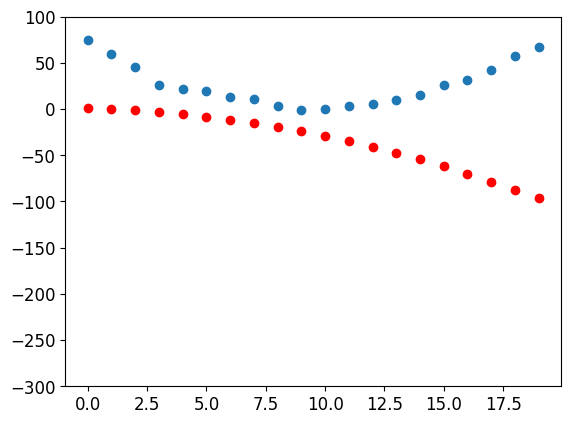

In [54]:
# A better prediction that the first time
show_preds(preds)


### Apply step multiple times
The whole step in a few instructions

In [55]:

def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn:
        print(loss.item())
    return preds


### Step 6 Apply step multiple times

In [56]:
for i in range(10):
    apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [57]:
# Reset params for the next example
params = origin_params.detach().requires_grad_()

Each step represents a new quadratic function. If we plot instead of printing.

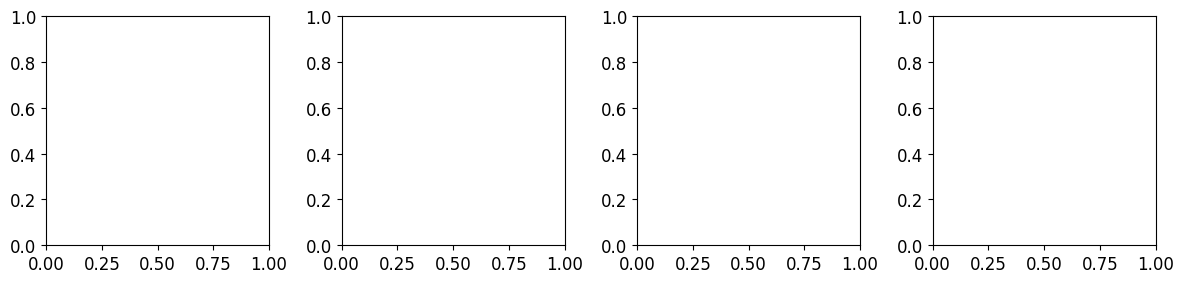

In [58]:

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()
    

## SummarySGD
- Initial weights can be random or come from a pretrained model


## SGD applied to MNIST data set
